In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='new_traffic_signs.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('new_traffic_signs.zip')
f.keys()
!unzip new_traffic_signs.zip

Streaming output truncated to the last 5000 lines.
  inflating: traffic signs/train/crossroad with side road on the right/crossroad with side road on the right198.jpg  
  inflating: traffic signs/train/crossroad with side road on the right/crossroad with side road on the right199.jpg  
  inflating: traffic signs/train/crossroad with side road on the right/crossroad with side road on the right2.jpg  
  inflating: traffic signs/train/crossroad with side road on the right/crossroad with side road on the right200.jpg  
  inflating: traffic signs/train/crossroad with side road on the right/crossroad with side road on the right202.jpg  
  inflating: traffic signs/train/crossroad with side road on the right/crossroad with side road on the right203.jpg  
  inflating: traffic signs/train/crossroad with side road on the right/crossroad with side road on the right205.jpg  
  inflating: traffic signs/train/crossroad with side road on the right/crossroad with side road on the right206.jpg  
  infla

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.11.0


In [ ]:
train_dir = 'traffic signs/train'
validation_dir = 'traffic signs/val'
test_dir = 'traffic signs/test'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
no_classes = 13

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 5092 files belonging to 13 classes.
Found 1515 files belonging to 13 classes.
Found 815 files belonging to 13 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

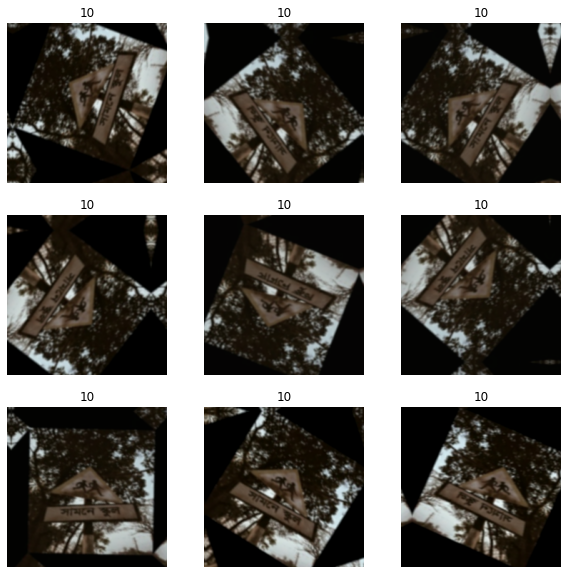

In [ ]:
import numpy as np

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = img_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
base_model = keras.applications.InceptionV3(
    weights=None,  
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
nb_classes = 13
inputs = keras.Input(shape=(224, 224, 3))
x = img_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = Dense(nb_classes, activation="softmax")(x)
#outputs = keras.layers.Dense(13)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0     

In [ ]:
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy',metrics =['accuracy']) 

In [ ]:
epochs = 50
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

Epoch 1/50


160/160 [==============================] - 137s 550ms/step - loss: 2.4873 - accuracy: 0.1365 - val_loss: 2.3182 - val_accuracy: 0.1505
Epoch 2/50
160/160 [==============================] - 84s 518ms/step - loss: 2.2846 - accuracy: 0.1966 - val_loss: 2.1957 - val_accuracy: 0.2191
Epoch 3/50
160/160 [==============================] - 83s 517ms/step - loss: 2.1276 - accuracy: 0.2541 - val_loss: 1.9037 - val_accuracy: 0.2937
Epoch 4/50
160/160 [==============================] - 83s 518ms/step - loss: 1.8731 - accuracy: 0.3309 - val_loss: 1.8675 - val_accuracy: 0.3300
Epoch 5/50
160/160 [==============================] - 83s 514ms/step - loss: 1.7462 - accuracy: 0.3934 - val_loss: 1.4824 - val_accuracy: 0.4733
Epoch 6/50
160/160 [==============================] - 83s 521ms/step - loss: 1.6329 - accuracy: 0.4429 - val_loss: 1.2969 - val_accuracy: 0.5716
Epoch 7/50
160/160 [==============================] - 83s 515ms/step - loss: 1.4804 - accuracy: 0.4894 - val_loss: 1.2148 - val_accuracy: 0.

In [ ]:
scores = model.evaluate(test_dataset)

26/26 [==============================] - 3s 111ms/step - loss: 0.1097 - accuracy: 0.9632


In [ ]:
class_names = test_dataset.class_names
class_names

['Market in front',
 'Mosque in front',
 'college in front',
 'crossing',
 'crossroad',
 'crossroad with a side road on the left',
 'crossroad with side road on the right',
 'curve to the left',
 'curve to the right',
 'railroad crossing',
 'school in front',
 'speed bump',
 'speed limit']

first image to predict
actual label: speed limit
1/1 [==============================] - 1s 1s/step
predicted label: speed limit


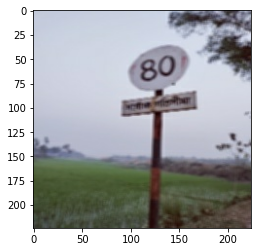

In [ ]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


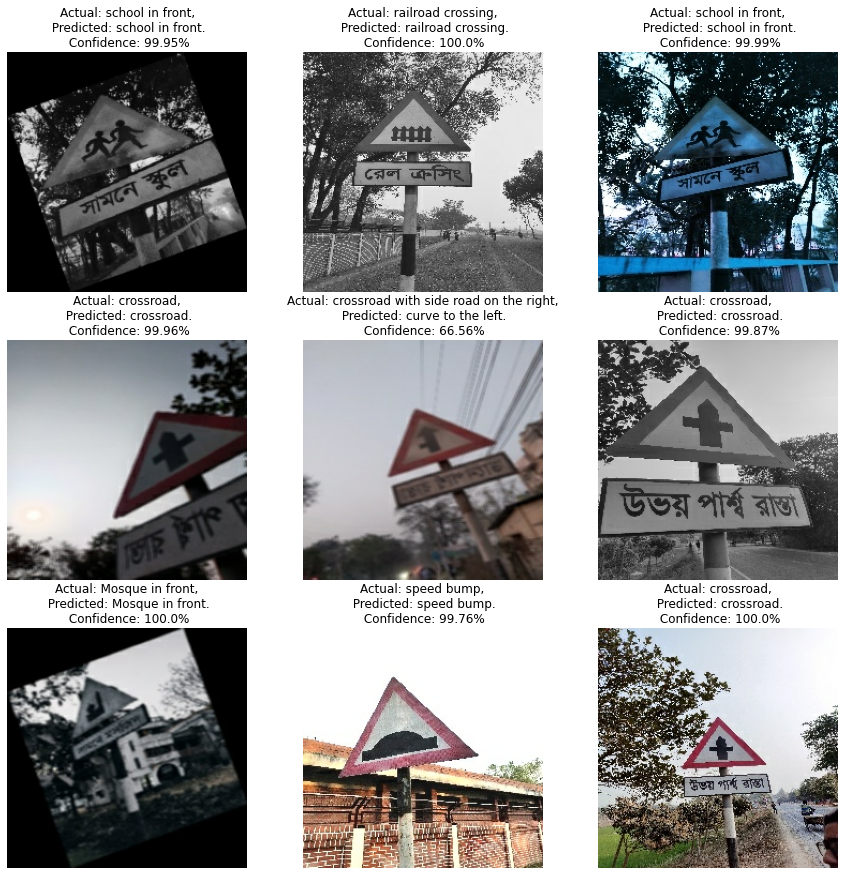

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='test.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('test.zip')
f.keys()
!unzip test.zip

Archive:  test.zip
   creating: test/
  inflating: test/IMG20230228181526.jpg  
  inflating: test/IMG20230228181936.jpg  
  inflating: test/IMG20230228181937.jpg  
  inflating: test/IMG_20230228_153940.jpg  
  inflating: test/IMG_20230228_154105 (2).jpg  
  inflating: test/IMG_20230228_154121 (2).jpg  
  inflating: test/IMG_20230228_154132.jpg  
  inflating: test/IMG_20230228_154413.jpg  
  inflating: test/IMG_20230228_154501.jpg  
  inflating: test/IMG_20230228_154502.jpg  
  inflating: test/IMG_20230228_155100.jpg  
  inflating: test/IMG_20230228_155102.jpg  
  inflating: test/IMG_20230228_155113.jpg  
  inflating: test/IMG_20230228_155545.jpg  
  inflating: test/IMG_20230228_155547.jpg  
  inflating: test/IMG_20230228_155640.jpg  
  inflating: test/IMG_20230228_155710.jpg  
  inflating: test/IMG_20230228_155716.jpg  
  inflating: test/IMG_20230228_160628.jpg  
  inflating: test/IMG_20230228_161901.jpg  
  inflating: test/IMG_20230228_162133.jpg  
  inflating: test/IMG_20230228_16221

In [ ]:
image_to_predict = [
    "/content/test/IMG20230228181526.jpg", 
    "/content/test/IMG20230228181936.jpg",
    "/content/test/IMG20230228181937.jpg",
    "/content/test/IMG_20230228_153940.jpg",
   "/content/test/IMG_20230228_154105 (2).jpg",
    "/content/test/IMG_20230228_154121 (2).jpg",
    "/content/test/IMG_20230228_154132.jpg",
    "/content/test/IMG_20230228_154413.jpg",
    "/content/test/IMG_20230228_154501.jpg",
    "/content/test/IMG_20230228_154502.jpg",
    "/content/test/IMG_20230228_155113.jpg",
    "/content/test/IMG_20230228_155545.jpg",
    "/content/test/IMG_20230228_155547.jpg",
    "/content/test/IMG_20230228_155640.jpg",
    "/content/test/IMG_20230228_155710.jpg",
    "/content/test/IMG_20230228_155716.jpg",
    "/content/test/IMG_20230228_160628.jpg",
    "/content/test/IMG_20230228_161901.jpg",
    "/content/test/IMG_20230228_162133.jpg",
    "/content/test/IMG_20230228_162218.jpg",
    "/content/test/IMG_20230228_162229 (2).jpg",
    "/content/test/IMG_20230228_162333.jpg",
    "/content/test/IMG_20230228_163326.jpg",
    "/content/test/IMG_20230228_163406.jpg",
    "/content/test/IMG_20230228_163739.jpg",
    "/content/test/IMG_20230228_163741.jpg",
    "/content/test/IMG_20230228_163827 (2).jpg",
    "/content/test/IMG_20230228_175945.jpg",
    "/content/test/IMG_20230228_180036.jpg",
    "/content/test/IMG_20230228_180050 (2).jpg",
    "/content/test/IMG_20230228_181559.jpg",
    "/content/test/IMG_20230228_181807.jpg",
    "/content/test/IMG_20230228_182024.jpg",
    "/content/test/IMG_20230228_182147.jpg",
    "/content/test/IMG_20230228_182211.jpg",
    "/content/test/IMG_20230228_182239.jpg",
    "/content/test/IMG_20230228_182339.jpg",
    "/content/test/IMG_20230228_182340.jpg",
    "/content/test/IMG_20230228_155100.jpg",
    "/content/test/IMG_20230228_155102.jpg"

  

    ]
for imgi in image_to_predict:
  img = keras.utils.load_img(imgi, target_size=(224,224))
  ix = keras.utils.img_to_array(img)
  ix = np.expand_dims(ix, axis=0)
  prediction = model.predict(ix)
  cls = tf.argmax(prediction[0], axis=-1)
  print(prediction, cls)
  print(f'{class_names[cls]} --> {imgi}')

1/1 [==============================] - 0s 52ms/step
[[2.9108596e-09 5.7538545e-01 8.8578513e-09 6.1291576e-07 2.5083055e-11
  2.6630094e-06 3.0575535e-07 4.2459798e-01 3.6078086e-07 4.4931580e-06
  1.8137323e-11 8.1173648e-06 7.3015769e-12]] tf.Tensor(1, shape=(), dtype=int64)
Mosque in front --> /content/test/IMG20230228181526.jpg
1/1 [==============================] - 0s 59ms/step
[[2.5893000e-04 9.0031223e-03 2.8521266e-05 8.3381468e-10 6.6576291e-08
  1.3229422e-07 9.7271156e-01 1.7954804e-02 2.2685959e-05 4.1096228e-06
  9.0581000e-15 1.6103808e-05 2.1354947e-14]] tf.Tensor(6, shape=(), dtype=int64)
crossroad with side road on the right --> /content/test/IMG20230228181936.jpg
1/1 [==============================] - 0s 45ms/step
[[3.5618159e-05 1.5471323e-02 6.7497510e-04 2.0610904e-09 1.0543166e-07
  5.6961039e-07 9.4474423e-01 3.8693324e-02 1.7044409e-04 1.6364116e-04
  7.3065828e-14 4.5775294e-05 2.4188383e-15]] tf.Tensor(6, shape=(), dtype=int64)
crossroad with side road on the 

In [ ]:
'''
IMG_20230228_153940 = crossroad (+1)
IMG_20230228_154501 = crossroad (+1)
IMG_20230228_154502 = crossroad (+1)

IMG_20230228_154105 (2) = market in front (+1)
IMG_20230228_154121 (2)= market in front (+1)
IMG_20230228_154132 = market in front (+1)

IMG_20230228_154413 = curve to the left (+1)
IMG_20230228_155545 = curve to the left (+1)
IMG_20230228_155547 = curve to the left (+1)
IMG_20230228_160628 = curve to the left (+1)

IMG_20230228_155100 = curve to the right (+1)
IMG_20230228_155102 = curve to the right (+1)
IMG_20230228_155113  = curve to the right (+1)

IMG_20230228_155640 = crossing (+1)
IMG_20230228_155710 = crossing (+1)
IMG_20230228_155716 = crossing (-1) predict (curve to the left)

IMG_20230228_161901 = speed bump (+1)
IMG_20230228_162218 =  speed bump (+1)
IMG_20230228_162229 (2) =  speed bump (+1)

IMG_20230228_163326  = railroad crossing (+1)
IMG_20230228_163406 = railroad crossing (+1)
IMG_20230228_162133 = railroad crossing (+1)

IMG_20230228_163739 = college in front (+1)
IMG_20230228_163741 = college in front (+1)
IMG_20230228_163827 (2) = college in front (+1)

IMG_20230228_175945 = speed limit (+1)
IMG_20230228_180036 = speed limit (+1)
IMG_20230228_180050 (2) = speed limit (+1)

IMG_20230228_181559 = Mosque in front (+1)
IMG_20230228_181807 = Mosque in front (+1)
IMG20230228181526 = Mosque in front (+1)

IMG_20230228_182147 = school in front (+1)
IMG_20230228_182211 = school in front (+1)
IMG_20230228_182239 = school in front (+1)

IMG_20230228_182339 = crossroad with a side road on the left (+1)
IMG_20230228_182340 = = crossroad with a side road on the left (+1)
IMG_20230228_162333 = crossroad with a side road on the left (+1)

IMG_20230228_182024 = crossroad with a side road on the right (+1)
IMG20230228181936 = crossroad with a side road on the right (+1)
IMG20230228181937 = crossroad with a side road on the right (+1)
'''

'\nIMG_20230228_153940 = crossroad (+1)\nIMG_20230228_154501 = crossroad (+1)\nIMG_20230228_154502 = crossroad (+1)\n\nIMG_20230228_154105 (2) = market in front (+1)\nIMG_20230228_154121 (2)= market in front (+1)\nIMG_20230228_154132 = market in front (+1)\n\nIMG_20230228_154413 = curve to the left (+1)\nIMG_20230228_155545 = curve to the left (+1)\nIMG_20230228_155547 = curve to the left (+1)\nIMG_20230228_160628 = curve to the left (+1)\n\nIMG_20230228_155100 = curve to the right (+1)\nIMG_20230228_155102 = curve to the right (+1)\nIMG_20230228_155113  = curve to the right (+1)\n\nIMG_20230228_155640 = crossing (+1)\nIMG_20230228_155710 = crossing (+1)\nIMG_20230228_155716 = crossing (+1)\n\nIMG_20230228_161901 = speed bump (+1)\nIMG_20230228_162218 =  speed bump (+1)\nIMG_20230228_162229 (2) =  speed bump (+1)\n\nIMG_20230228_163326  = railroad crossing (+1)\nIMG_20230228_163406 = railroad crossing (+1)\nIMG_20230228_162133 = railroad crossing (+1)\n\nIMG_20230228_163739 = college i

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from keras.models import load_model

def predict(file):
  x = load_img(file, target_size=(224, 224))
  x = img_to_array(x)
  x = np.expand_dims(x, axis=0)
  array = model.predict(x)
  result = array[0]
  answer = np.argmax(result)
  if answer == 0:
    print("pred: Market in front")
  elif answer == 1:
    print("pred: Mosque in front")
  elif answer == 2:
    print("pred: college in front")
  elif answer == 3:
    print("pred: crossing")
  elif answer == 4:
    print("pred: crossroad")
  elif answer == 5:
    print("pred: crossroad with a side road on the left")
  elif answer == 6:
    print("pred: crossroad with side road on the right")
  elif answer == 7:
    print("pred: curve to the left")
  elif answer == 8:
    print("pred: curve to the right")
  elif answer == 9:
    print("pred: railroad crossing")
  elif answer == 10:
    print("pred: school in front")
  elif answer == 11:
    print("pred: speed bump")
  elif answer == 12:
    print("pred:speed limit")

  
  return answer
predict('/content/test/IMG20230228181526.jpg')

1/1 [==============================] - 0s 68ms/step
pred: Mosque in front


1